### 04 - HEAT WAVES IDENTIFICATION

#### 04.1 - Libraries import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import dask as ds
from datetime import datetime

#### 04.2 - Temporal patterns analysis
##### Here we start analyzing the datasets containing the temperatures, spanning across all years months days available from 11 am to 5 pm

In [4]:
# Open the file NetCDF

dataset_t1 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\2m_air_temp\air_temperature_era5-downscaled-over-italy_hourly_81_00.nc")
dataset_t2 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\2m_air_temp\air_temperature_era5-downscaled-over-italy_hourly_01_23.nc")
dataset_tmax1 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-downscaled-over-italy_hourly_81_00.nc")
dataset_tmax2 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-downscaled-over-italy_hourly_01_23.nc")

#### 04.3 - Unione dei datasets

In [11]:
# Specifica la cartella di output e il nome del file unito
output_folder = (r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp")
output_file = "max_temperature_era5-81_23.nc"

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Apri i dataset
ds1 = dataset_tmax1
ds2 = dataset_tmax2

# Unisci i dataset
merged_ds = xr.concat([ds1, ds2], dim="time")

# Salva il dataset unito in un nuovo file NetCDF
output_path = os.path.join(output_folder, output_file)
merged_ds.to_netcdf(output_path)

print(f'Dataset unito salvato in: {output_path}')

Dataset unito salvato in: C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc


In [5]:
dataset_tmax = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc")
dataset_t = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\2m_air_temp\air_temperature_era5-81_23.nc")

In [48]:
dataset_tmax

<xarray.Dataset>
Dimensions:                         (time: 109935, rlat: 103, rlon: 114)
Coordinates:
    lon                             (rlat, rlon) float32 ...
    height_2m                       float32 ...
  * rlon                            (rlon) float64 -2.553 -2.533 ... -0.2932
  * rlat                            (rlat) float64 1.652 1.672 ... 3.672 3.692
    lat                             (rlat, rlon) float32 ...
  * time                            (time) datetime64[ns] 1981-01-01T11:00:00...
Data variables:
    TMAX_2M                         (time, rlat, rlon) float32 ...
    crs_rotated_latitude_longitude  (time) int64 ...
Attributes: (12/14)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    history:         Generated by CMCC DDS version 0.9.0 2025-03-26 09:15:33....
    source:          COSMO
    institution:     CMCC (Euro-Mediterranean Center on Climate Change), REMH...
    title:           cclm-sp_2.4_terra_urb_2.3.1 simulation (0.02 Deg) forced...
    ...              ...
    conventionsURL:  http://www.cfconventions.org/
    contact:         Mario Raffa (mario.raffa@cmcc.it)- Marianna Adinolfi (ma...
    references:      http//www.clm-community.eu, http://www.cmcc.it
    creation_date:   2022-10-22 00:28:52
    grid_mapping:    rotated_pole
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...

#### 04.4 - Analisi media annua e mensile su tutto il dataset

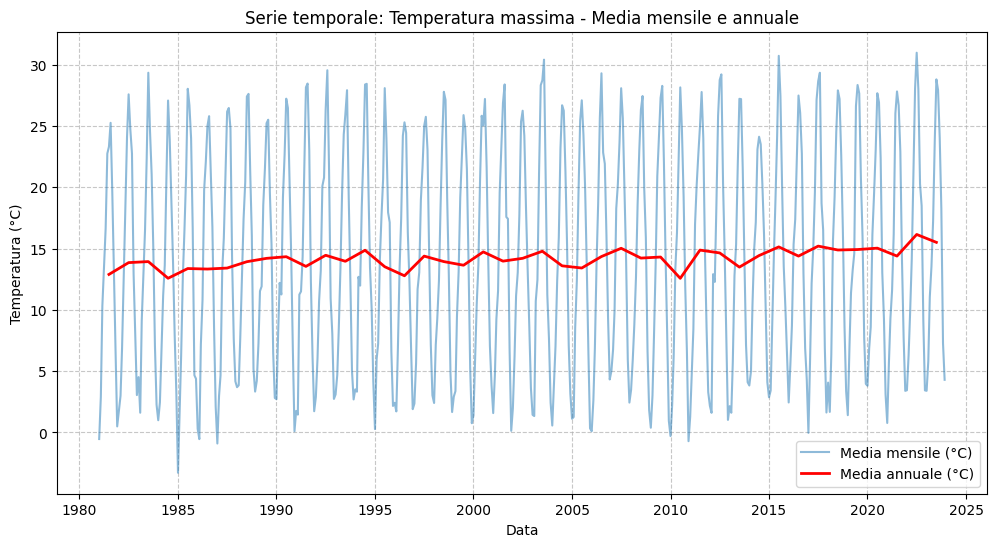

In [5]:
# Applica il chunking al dataset già caricato per lavorare con Dask
ds = dataset_tmax.chunk({"time": 365, "rlat": 50, "rlon": 50})

# Seleziona la variabile di interesse (assicurati che il nome sia corretto, qui "TMAX_2M")
temp_var = ds["TMAX_2M"]

# 1) Calcolo della media spaziale giornaliera (riducendo rlat, rlon)
temp_mean = temp_var.mean(dim=["rlat", "rlon"]) - 273.15  # da K a °C
temp_mean_computed = temp_mean.compute()

# 2) Conversione in DataFrame e creazione di colonne 'year' e 'month'
df_mean = temp_mean_computed.to_dataframe().reset_index()  # 'time' diventa colonna
df_mean['year'] = df_mean['time'].dt.year
df_mean['month'] = df_mean['time'].dt.month

# 3) Raggruppo per (year, month) per ottenere la media mensile
monthly_mean = df_mean.groupby(['year', 'month'])['TMAX_2M'].mean().reset_index()

# 4) Raggruppo per year per ottenere la media annuale
annual_mean = df_mean.groupby('year')['TMAX_2M'].mean().reset_index()

# 5) Creazione di una colonna 'date' fittizia per plottare la serie mensile
#    (usiamo il 1° giorno di ogni mese)
monthly_mean['date'] = pd.to_datetime(dict(
    year=monthly_mean['year'],
    month=monthly_mean['month'],
    day=1
))
monthly_mean.sort_values('date', inplace=True)

#    Per l'annuale, creiamo una data fittizia (es. 1° luglio) per ogni anno
annual_mean['date'] = pd.to_datetime(dict(
    year=annual_mean['year'],
    month=7,   # mese "centrale" dell'anno
    day=1
))
annual_mean.sort_values('date', inplace=True)

# 6) Plot delle due serie (mensile e annuale) in un unico grafico
plt.figure(figsize=(12, 6))

# Media mensile
plt.plot(
    monthly_mean['date'],
    monthly_mean['TMAX_2M'],
    label="Media mensile (°C)",
    alpha=0.5
)

# Media annuale
plt.plot(
    annual_mean['date'],
    annual_mean['TMAX_2M'],
    label="Media annuale (°C)",
    color="red",
    linewidth=2
)

plt.xlabel("Data")
plt.ylabel("Temperatura (°C)")
plt.title("Serie temporale: Temperatura massima - Media mensile e annuale")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

#### 04.5 - Definizione delle soglie per ciascun giorno con finestra a 15 e a 31 giorni

In [15]:
start = datetime.now()

def compute_dayofyear_thresholds(
    ds, 
    var_name, 
    percentile, 
    window_1, 
    window_2
):
    """
    Calcola per ciascun day_of_year due soglie:
      - threshold_15: basata su una finestra centrata di 15 giorni
      - threshold_31: basata su una finestra centrata di 31 giorni
    
    Restituisce un DataFrame con:
      day_of_year, threshold_15, threshold_31
    """
    # Aggiunge una coordinata "dayofyear"
    ds = ds.assign_coords(dayofyear=ds.time.dt.dayofyear)

    half_1 = window_1 // 2
    half_2 = window_2 // 2

    results = []

    for d in range(1, 366):
        # Finestra 15 giorni (±7)
        day_min_1 = d - half_1
        day_max_1 = d + half_1
        ds_w1 = ds.where(
            (ds.dayofyear >= day_min_1) & (ds.dayofyear <= day_max_1),
            drop=True
        ).chunk({"time": -1, "rlat": -1, "rlon": -1})  # Rechunk per avere chunk unici
        
        if ds_w1[var_name].size > 0:
            threshold_15 = ds_w1[var_name].quantile(
                percentile, dim=["time", "rlat", "rlon"]
            ).compute()
            threshold_15_val = float(threshold_15.values)
        else:
            threshold_15_val = np.nan

        # Finestra 31 giorni (±15)
        day_min_2 = d - half_2
        day_max_2 = d + half_2
        ds_w2 = ds.where(
            (ds.dayofyear >= day_min_2) & (ds.dayofyear <= day_max_2),
            drop=True
        ).chunk({"time": -1, "rlat": -1, "rlon": -1})
        
        if ds_w2[var_name].size > 0:
            threshold_31 = ds_w2[var_name].quantile(
                percentile, dim=["time", "rlat", "rlon"]
            ).compute()
            threshold_31_val = float(threshold_31.values)
        else:
            threshold_31_val = np.nan

        results.append({
            "day_of_year": d,
            "threshold_15": threshold_15_val,
            "threshold_31": threshold_31_val
        })

    df_thresholds = pd.DataFrame(results)
    return df_thresholds


# CALCOLIAMO ADESSO LE SOGLIE PER CIASCUN GIORNO DEL DATASET
# Applica il chunking al dataset già caricato per lavorare con Dask
dataset_tmax = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc")
ds = dataset_tmax.chunk({"time": 365, "rlat": 50, "rlon": 50})

# Seleziona la variabile di interesse (assicurati che il nome sia corretto, qui "TMAX_2M")
temp_var = ds["TMAX_2M"]

df_thresholds = compute_dayofyear_thresholds(
    ds,
    var_name="TMAX_2M",  # Adatta al tuo dataset
    percentile=0.90,
    window_1=15,
    window_2=31
    )

end = datetime.now()
elapsed = end - start
print(f"Elapsed Time using datetime: {elapsed}")

In [2]:
df_thresholds

NameError: name 'df_thresholds' is not defined

In [ ]:
# Salva in CSV
df_thresholds.to_csv("thresholds_15_31.csv", index=False)
print("CSV salvato con le soglie per ciascun day_of_year.")